## MNIST Classification

In [1]:
!pip install mnist==0.2.2

## Import necessary libraries

In [2]:
import numpy as np
import mnist
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 6.0) 
plt.rcParams['image.cmap'] = 'gray'

## Get training and test set of images

In [3]:
train_images = mnist.train_images()[:1000]
train_labels = mnist.train_labels()[:1000]

test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

print("Shape of training image data: ", train_images.shape)
print("Shape of training labels: ", train_labels.shape)

print("Shape of test image data: ", test_images.shape)
print("Shape of test labels: ", test_labels.shape)

Shape of training image data:  (1000, 28, 28)
Shape of training labels:  (1000,)
Shape of test image data:  (1000, 28, 28)
Shape of test labels:  (1000,)


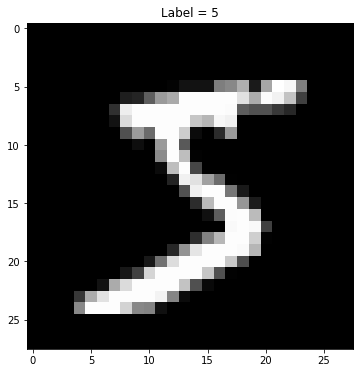

In [4]:
plt.title(f'Label = {train_labels[0]}')
plt.imshow(train_images[0,:,:])
plt.show()

## Convolutional Layer

In [5]:
class Conv3:
  ''' 
  3x3 CONV filter
  padding = same
  stride = 1
  input = 2D numpy array of MNIST data
  output = 3D numpy array
  ''' 

  def __init__(self, n_C):
    self.n_C = n_C

    # Xavier initialization
    self.W = np.random.randn(3, 3, n_C) / 3

  def iter_slices(self, img):
    n_H_prev, n_W_prev = img.shape

    # n_H = n_H_prev - f + 1
    # n_W = n_W_prev - f + 1
    n_H = n_H_prev - 2
    n_W = n_W_prev - 2

    for i in range(n_H):
      for j in range(n_W):
        img_slice = img[i:(i + 3), j:(j + 3)]
        yield img_slice, i, j

  def forward(self, A_prev):
    self.A_prev = A_prev

    n_H_prev, n_W_prev = A_prev.shape
    A = np.zeros((n_H_prev - 2, n_W_prev - 2, self.n_C))

    for img_slice, i, j in self.iter_slices(A_prev):
      A[i, j] = np.sum(img_slice[:,:,np.newaxis] * self.W, axis=(0,1))

    return A

  def backprop(self, dA, lr):
    dW = np.zeros(self.W.shape)

    for img_slice, i, j in self.iter_slices(self.A_prev):
      for c in range(self.n_C):
        dW[:,:,c] += dA[i, j, c] * img_slice

    # Update filter parameters
    self.W -= lr * dW

    return None

## Max Pooling Layer

In [6]:
class MaxPool2:
  ''' 2x2 Max Pool''' 

  def iter_slices(self, img):
    n_H_prev, n_W_prev, _ = img.shape

    # n_H = floor(n_H_prev / stride)
    # n_W = floor(n_W_prev / stride)
    n_H = n_H_prev // 2
    n_W = n_W_prev // 2

    for i in range(n_H):
      for j in range(n_W):
        img_slice = img[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield img_slice, i, j

  def forward(self, A_prev):
    self.A_prev = A_prev

    n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    A = np.zeros((n_H_prev // 2, n_W_prev // 2, n_C_prev))

    for img_slice, i, j in self.iter_slices(A_prev):
      for c in range(n_C_prev):
        A[i, j, c] = np.max(img_slice)

    return A

  def backprop(self, dA):
    dA_prev = np.zeros(self.A_prev.shape)

    for img_slice, i, j in self.iter_slices(self.A_prev):      
      dA_prev[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)] = (img_slice == np.max(img_slice, axis=(0,1))) * dA[i, j]

    return dA_prev

## Softmax Layer

In [7]:
class Dense:
  '''Fully connected layer for softmax regression'''

  def __init__(self, fan_in, fan_out):
    self.W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in)
    self.b = np.zeros(fan_out)

  def forward(self, A_prev):
    self.A_prev_shape = A_prev.shape

    A_prev = A_prev.flatten()
    self.A_prev = A_prev

    Z = np.dot(A_prev, self.W) + self.b
    self.Z = Z

    exp = np.exp(Z)
    A = exp / np.sum(exp, axis=0)
    self.A = A
    
    return A

  def backprop(self, label, lr):

    # Convert  label to on-hot vector
    label_oh = np.zeros(10)
    label_oh[label] = 1

    # Calculate dL/dZ = A - Y
    dZ = self.A - label_oh

    dW = np.dot(self.A_prev[np.newaxis].T, dZ[np.newaxis])
    db = np.sum(dZ, axis=0, keepdims=True)
    dA_prev = np.dot(dZ, self.W.T)

    # Update network parameters
    self.W -= lr * dW
    self.b -= lr * db

    return dA_prev.reshape(self.A_prev_shape)


In [8]:
# Initialize layer objects
conv = Conv3(10)
pool = MaxPool2()
softmax = Dense(13*13*10, 10)

# list to append loss & accuracy (per 100 steps)
loss_history = []
acc_history = []

# Forward propagation
def forward(image):
  out = conv.forward(image / 255.)
  out = pool.forward(out)
  out = softmax.forward(out)
  return out

# Backpropagation / training process
def train(image, label, lr=.005):
  grad = softmax.backprop(label, lr)
  grad = pool.backprop(grad)
  grad = conv.backprop(grad, lr)

print("--------------------Training initialized--------------------")

# Train the model for 5 epochs
for epoch in range(5):

  # Shuffle the training set
  perm = np.random.permutation(len(train_images))
  train_images = train_images[perm]
  train_labels = train_labels[perm]

  tot_loss = 0
  tot_acc = 0
  
  for i, (image, label) in enumerate(zip(train_images, train_labels)):
    if i > 0 and i % 100 == 99:
      print('[Epoch: %d / Step: %04d]: Average Loss %.3f | Accuracy: %d%%'%(epoch+1, i+1, tot_loss/100, tot_acc))
      loss_history.append(tot_loss)
      acc_history.append(tot_acc)
      tot_loss, tot_acc = 0, 0

    # Forward propagation
    out = forward(image)

    # Cross entropy loss & accuracy
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0
    
    # Back propagation
    train(image, label, lr=0.005)

    # Append loss & accuracy values
    tot_loss += loss
    tot_acc += acc

# Cross validation
print('\n-----------Validation step-----------')
tot_loss = 0
tot_acc = 0
for image, label in zip(test_images, test_labels):
  out = forward(image)
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0
  tot_loss += loss
  tot_acc += acc
m = len(test_images)
print('Average loss on test set: %.3f'%(tot_loss/m))
print('Percentage accuracy on test set: %.2f'%(tot_acc/m*100))

--------------------Training initialized--------------------
[Epoch: 1 / Step: 0100]: Average Loss 2.263 | Accuracy: 26%
[Epoch: 1 / Step: 0200]: Average Loss 1.113 | Accuracy: 63%
[Epoch: 1 / Step: 0300]: Average Loss 0.942 | Accuracy: 66%
[Epoch: 1 / Step: 0400]: Average Loss 0.919 | Accuracy: 67%
[Epoch: 1 / Step: 0500]: Average Loss 0.795 | Accuracy: 71%
[Epoch: 1 / Step: 0600]: Average Loss 0.726 | Accuracy: 76%
[Epoch: 1 / Step: 0700]: Average Loss 0.721 | Accuracy: 78%
[Epoch: 1 / Step: 0800]: Average Loss 0.708 | Accuracy: 79%
[Epoch: 1 / Step: 0900]: Average Loss 0.666 | Accuracy: 71%
[Epoch: 1 / Step: 1000]: Average Loss 0.588 | Accuracy: 83%
[Epoch: 2 / Step: 0100]: Average Loss 0.611 | Accuracy: 82%
[Epoch: 2 / Step: 0200]: Average Loss 0.655 | Accuracy: 79%
[Epoch: 2 / Step: 0300]: Average Loss 0.558 | Accuracy: 81%
[Epoch: 2 / Step: 0400]: Average Loss 0.345 | Accuracy: 89%
[Epoch: 2 / Step: 0500]: Average Loss 0.477 | Accuracy: 84%
[Epoch: 2 / Step: 0600]: Average Loss 0

## Plotting cross entropy loss and accuracy

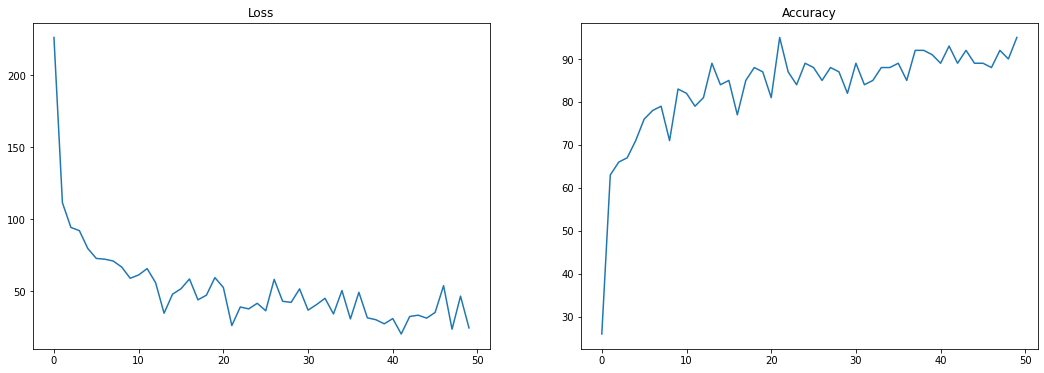

In [9]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.title('Accuracy')

plt.show()

## Testing out some examples unseen to the model

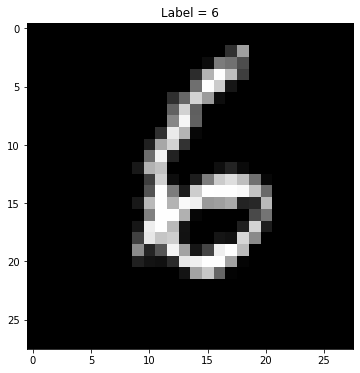

In [18]:
new_img = mnist.test_images()[2000]
new_label = mnist.test_labels()[2000]

plt.title(f'Label = {new_label}')
plt.imshow(new_img[:,:])
plt.show()

In [19]:
prediction = forward(new_img)

print("Ground truth label: ", new_label)
print("Predicted label: ", np.argmax(prediction))

Ground truth label:  6
Predicted label:  6


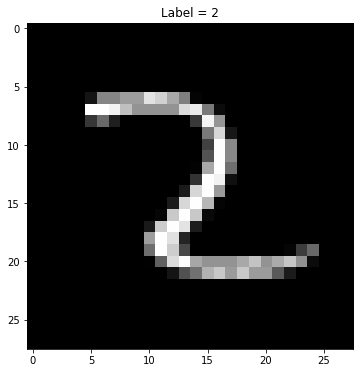

In [26]:
new_img = mnist.test_images()[2500]
new_label = mnist.test_labels()[2500]

plt.title(f'Label = {new_label}')
plt.imshow(new_img[:,:])
plt.show()

In [27]:
prediction = forward(new_img)

print("Ground truth label: ", new_label)
print("Predicted label: ", np.argmax(prediction))

Ground truth label:  2
Predicted label:  2


## One trickey example

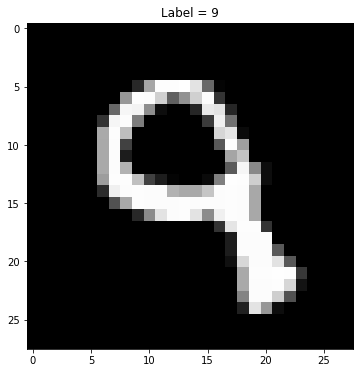

In [28]:
new_img = mnist.test_images()[4000]
new_label = mnist.test_labels()[4000]

plt.title(f'Label = {new_label}')
plt.imshow(new_img[:,:])
plt.show()

In [29]:
prediction = forward(new_img)

print("Ground truth label: ", new_label)
print("Predicted label: ", np.argmax(prediction))

Ground truth label:  9
Predicted label:  4
